# Predictive Modeling for Diabetes Risk

In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot, plot
import plotly.io as pio
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.ensemble import StackingClassifier
from imblearn.combine import SMOTETomek

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
df = pd.read_csv('./data/diabetes.csv')
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
284,2,108,80,0,0,27.0,0.259,52,1
427,1,181,64,30,180,34.1,0.328,38,1
58,0,146,82,0,0,40.5,1.781,44,0
653,2,120,54,0,0,26.8,0.455,27,0
359,1,196,76,36,249,36.5,0.875,29,1


In [3]:
print(f"Number of rows: {df.shape[0]}\nNumber of columns: {df.shape[1]}")

Number of rows: 768
Number of columns: 9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
print("\nNull values per column:")
print(df.isna().sum())


Null values per column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
pd.DataFrame({
    'count': df.shape[0],
    'null': df.isnull().sum(),
    'nullPercent': df.isnull().mean() * 100,
    'zeros': (df == 0).sum(),
    'zerosPercent': (df == 0).mean() * 100,
    'uniqueValues': df.nunique(),
    'min': df.min(),
    'max': df.max()
})

,count,null,nullPercent,zeros,zerosPercent,uniqueValues,min,max
Pregnancies,768,0,0.0,111,14.453125,17,0.000,17.00
Glucose,768,0,0.0,5,0.651042,136,0.000,199.00
BloodPressure,768,0,0.0,35,4.557292,47,0.000,122.00
SkinThickness,768,0,0.0,227,29.557292,51,0.000,99.00
Insulin,768,0,0.0,374,48.697917,186,0.000,846.00
BMI,768,0,0.0,11,1.432292,248,0.000,67.10
DiabetesPedigreeFunction,768,0,0.0,0,0.000000,517,0.078,2.42
Age,768,0,0.0,0,0.000000,52,21.000,81.00
Outcome,768,0,0.0,500,65.104167,2,0.000,1.00


#### Handling missing values:

In [8]:
zeroAsMissing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

dfClean = df.copy()
dfClean[zeroAsMissing] = dfClean[zeroAsMissing].replace(0, np.nan)

In [9]:
print("Null values after transformation:")
print(dfClean.isna().sum())

Null values after transformation:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [10]:
print(f"\nPercentage of null values per column:")
print((dfClean.isna().sum() / len(dfClean) * 100).round(2))


Percentage of null values per column:
Pregnancies                  0.00
Glucose                      0.65
BloodPressure                4.56
SkinThickness               29.56
Insulin                     48.70
BMI                          1.43
DiabetesPedigreeFunction     0.00
Age                          0.00
Outcome                      0.00
dtype: float64


#### Improved approach to handling missing values

In [11]:
def imputeMissingValues(df):
    dfImputed = df.copy()
    for col in zeroAsMissing:
        # 1. Impute using the median by diabetes class
        medianByOutcome = dfImputed.groupby('Outcome')[col].transform('median')
        
        # 2. Consider age groups for more specific imputation
        dfImputed['ageGroup'] = pd.cut(dfImputed['Age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle', 'Elderly'])
        
        for ageGroup in dfImputed['ageGroup'].unique():
            for outcome in [0, 1]:
                mask = (dfImputed['ageGroup'] == ageGroup) & (dfImputed['Outcome'] == outcome) & (dfImputed[col].isna())
                groupMedian = dfImputed[(dfImputed['ageGroup'] == ageGroup) & (dfImputed['Outcome'] == outcome)][col].median()
                
                if pd.isna(groupMedian): # If there's not enough data in the group, use the general median by outcome
                    dfImputed.loc[mask, col] = medianByOutcome[mask]
                else:
                    dfImputed.loc[mask, col] = groupMedian
        
        # 3. For values that are still NaN, use the general median by outcome
        dfImputed.loc[dfImputed[col].isna(), col] = medianByOutcome
    
    dfImputed = dfImputed.drop('ageGroup', axis=1)    
    return dfImputed


In [12]:
dfImputed = imputeMissingValues(dfClean)

In [13]:
print("Null values after imputation:")
print(dfImputed.isna().sum())

Null values after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


#### Improved outlier detection

In [14]:
def identifyOutliers(df, columns, threshold=1.5):
    outlierIndices = {}
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)

        IQR = Q3 - Q1

        lowerBound = Q1 - threshold * IQR
        upperBound = Q3 + threshold * IQR
        
        outliers = df[(df[col] < lowerBound) | (df[col] > upperBound)].index.tolist()
        outlierIndices[col] = outliers 
    
    return outlierIndices


In [15]:
numericalColumns = dfImputed.columns.drop('Outcome').tolist()
outliers = identifyOutliers(dfImputed, numericalColumns)

In [16]:
for col, indices in outliers.items():
    print(f"{col}: {len(indices)} outliers detected ({len(indices) / len(dfImputed)*100:.2f}%)")

Pregnancies: 4 outliers detected (0.52%)
Glucose: 0 outliers detected (0.00%)
BloodPressure: 14 outliers detected (1.82%)
SkinThickness: 53 outliers detected (6.90%)
Insulin: 45 outliers detected (5.86%)
BMI: 8 outliers detected (1.04%)
DiabetesPedigreeFunction: 29 outliers detected (3.78%)
Age: 9 outliers detected (1.17%)


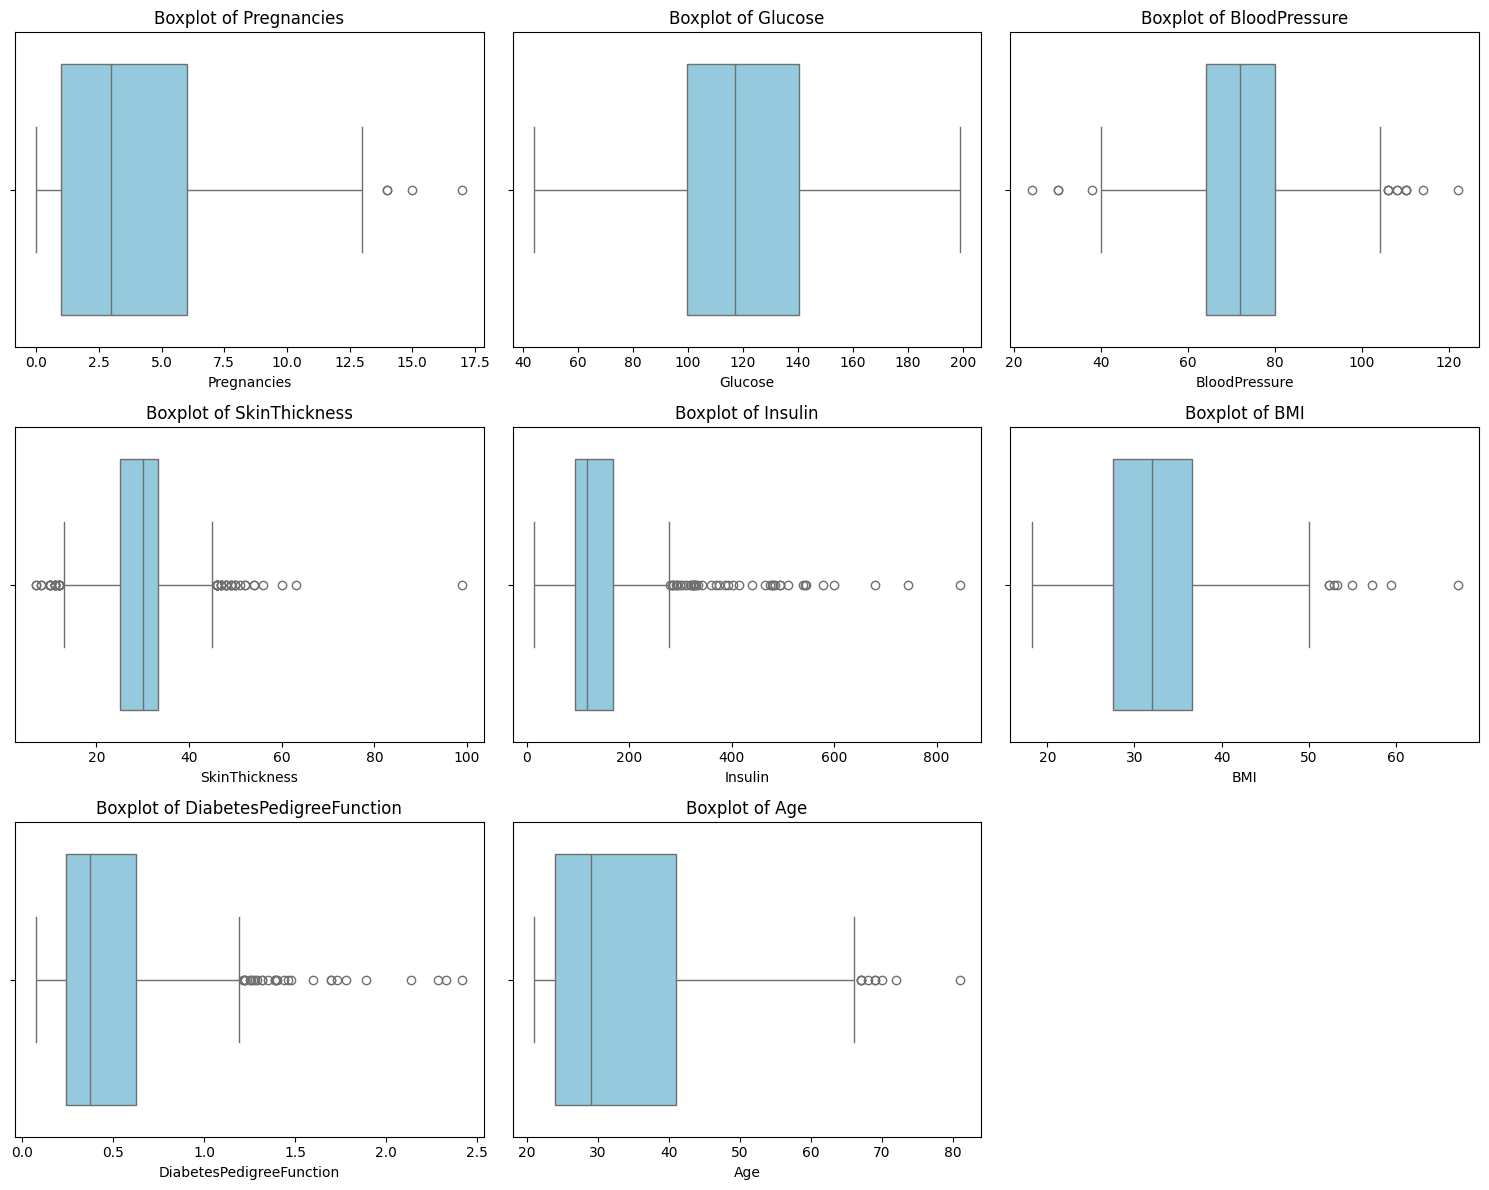

In [17]:
plt.figure(figsize=(15, 12))
for i, col in enumerate(numericalColumns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=dfImputed[col], color="skyblue")
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

#### Winsorization instead of removing outliers

In [18]:
def winsorizeOutliers(df, columns, threshold=1.5):
    dfWinsorized = df.copy()
    
    for col in columns:
        Q1 = dfWinsorized[col].quantile(0.25)
        Q3 = dfWinsorized[col].quantile(0.75)
        IQR = Q3 - Q1

        lowerBound = Q1 - threshold * IQR
        upperBound = Q3 + threshold * IQR
        
        dfWinsorized.loc[dfWinsorized[col] < lowerBound, col] = lowerBound # below the lower bound
        dfWinsorized.loc[dfWinsorized[col] > upperBound, col] = upperBound # above the upper bound
    
    return dfWinsorized


In [19]:
dfWinsorized = winsorizeOutliers(dfImputed, numericalColumns)

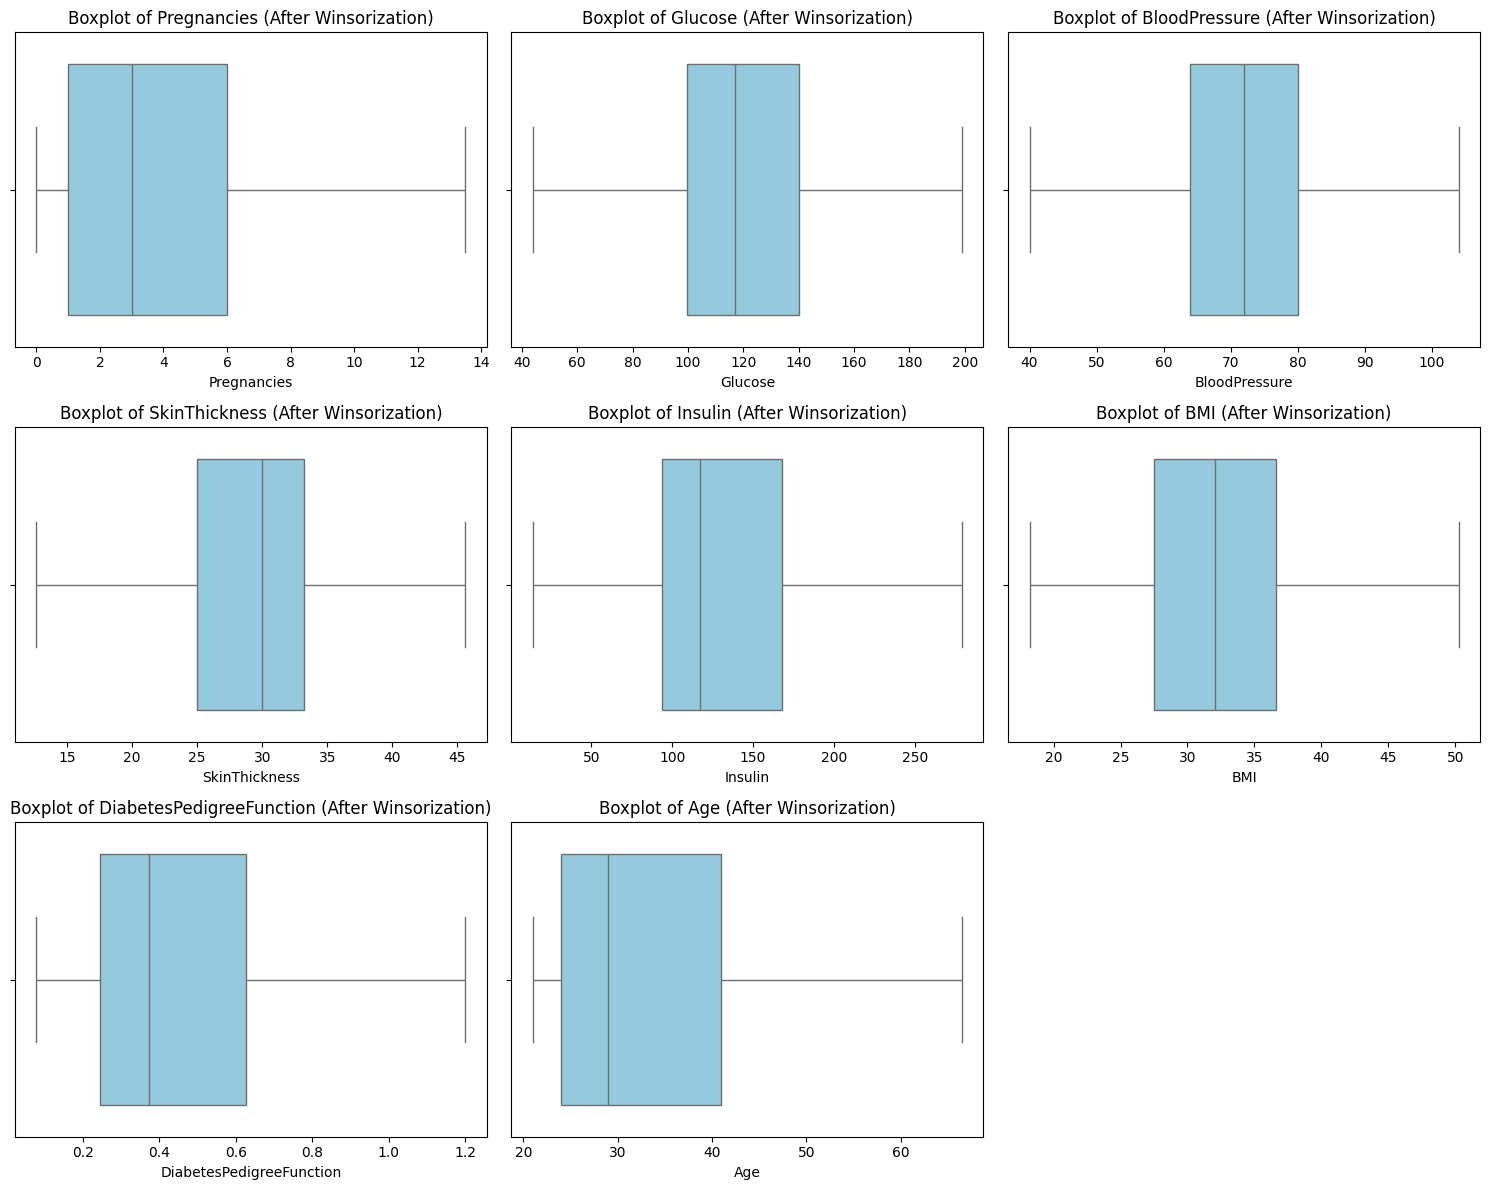

In [20]:
plt.figure(figsize=(15, 12))
for i, col in enumerate(numericalColumns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=dfWinsorized[col], color="skyblue")
    plt.title(f"Boxplot of {col} (After Winsorization)")
plt.tight_layout()
plt.show()

#### Feature engineering --> hold up, let me cook :?

In [21]:
def createFeatures(df):
    dfFeatures = df.copy()
    
    dfFeatures['bmiAgeRatio'] = dfFeatures['BMI'] / dfFeatures['Age'] # BMI-Age Ratio
    dfFeatures['bmgi'] = dfFeatures['BMI'] * dfFeatures['Glucose'] / 100 # Body Mass Glycemic Index
    dfFeatures['insulinResistance'] = dfFeatures['Glucose'] / dfFeatures['Insulin'].replace(0, 1) # Insulin Resistance Index
    dfFeatures['metabolicIndex'] = (dfFeatures['BMI'] * dfFeatures['Glucose'] * dfFeatures['BloodPressure']) / (dfFeatures['Age'] * 1000)   # Metabolic Health Index
    dfFeatures['ageAdjustedRisk'] = dfFeatures['DiabetesPedigreeFunction'] * np.log1p(dfFeatures['Age'])  # Age-Adjusted Genetic Risk
    
    # Categorize variables
    dfFeatures['glucoseCategory'] = pd.cut(dfFeatures['Glucose'], bins=[0, 99, 125, float('inf')], labels=['Normal', 'Prediabetes', 'Diabetes']) # Glucose
    dfFeatures['bmiCategory'] = pd.cut(dfFeatures['BMI'], bins=[0, 18.5, 24.9, 29.9, 34.9, float('inf')], labels=['Underweight', 'Normal', 'Overweight', 'ObeseClass1', 'ObeseClass2Plus']) # BMI
    
    # Convert categories to dummy variables
    dfFeatures = pd.get_dummies(dfFeatures, columns=['glucoseCategory', 'bmiCategory'], drop_first=True)
    
    return dfFeatures

In [22]:
dfFeatures = createFeatures(dfWinsorized)

In [23]:
print("New features created:")
print(dfFeatures.columns.tolist())
dfFeatures.head()

New features created:
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'bmiAgeRatio', 'bmgi', 'insulinResistance', 'metabolicIndex', 'ageAdjustedRisk', 'glucoseCategory_Prediabetes', 'glucoseCategory_Diabetes', 'bmiCategory_Normal', 'bmiCategory_Overweight', 'bmiCategory_ObeseClass1', 'bmiCategory_ObeseClass2Plus']


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,bmiAgeRatio,bmgi,insulinResistance,metabolicIndex,ageAdjustedRisk,glucoseCategory_Prediabetes,glucoseCategory_Diabetes,bmiCategory_Normal,bmiCategory_Overweight,bmiCategory_ObeseClass1,bmiCategory_ObeseClass2Plus
0,6.0,148.0,72.0,35.0,168.0,33.6,0.627,50.0,1,0.672000,49.728,0.880952,7.160832,2.465255,False,True,False,False,True,False
1,1.0,85.0,66.0,29.0,110.0,26.6,0.351,31.0,0,0.858065,22.610,0.772727,4.813742,1.216473,False,False,False,True,False,False
2,8.0,183.0,64.0,32.0,168.0,23.3,0.672,32.0,1,0.728125,42.639,1.089286,8.527800,2.349653,False,True,True,False,False,False
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,1.338095,25.009,0.946809,7.859971,0.516204,False,False,False,True,False,False
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,1,1.306061,59.047,0.815476,7.157212,4.231633,False,True,False,False,False,True


#### Correlation analysis

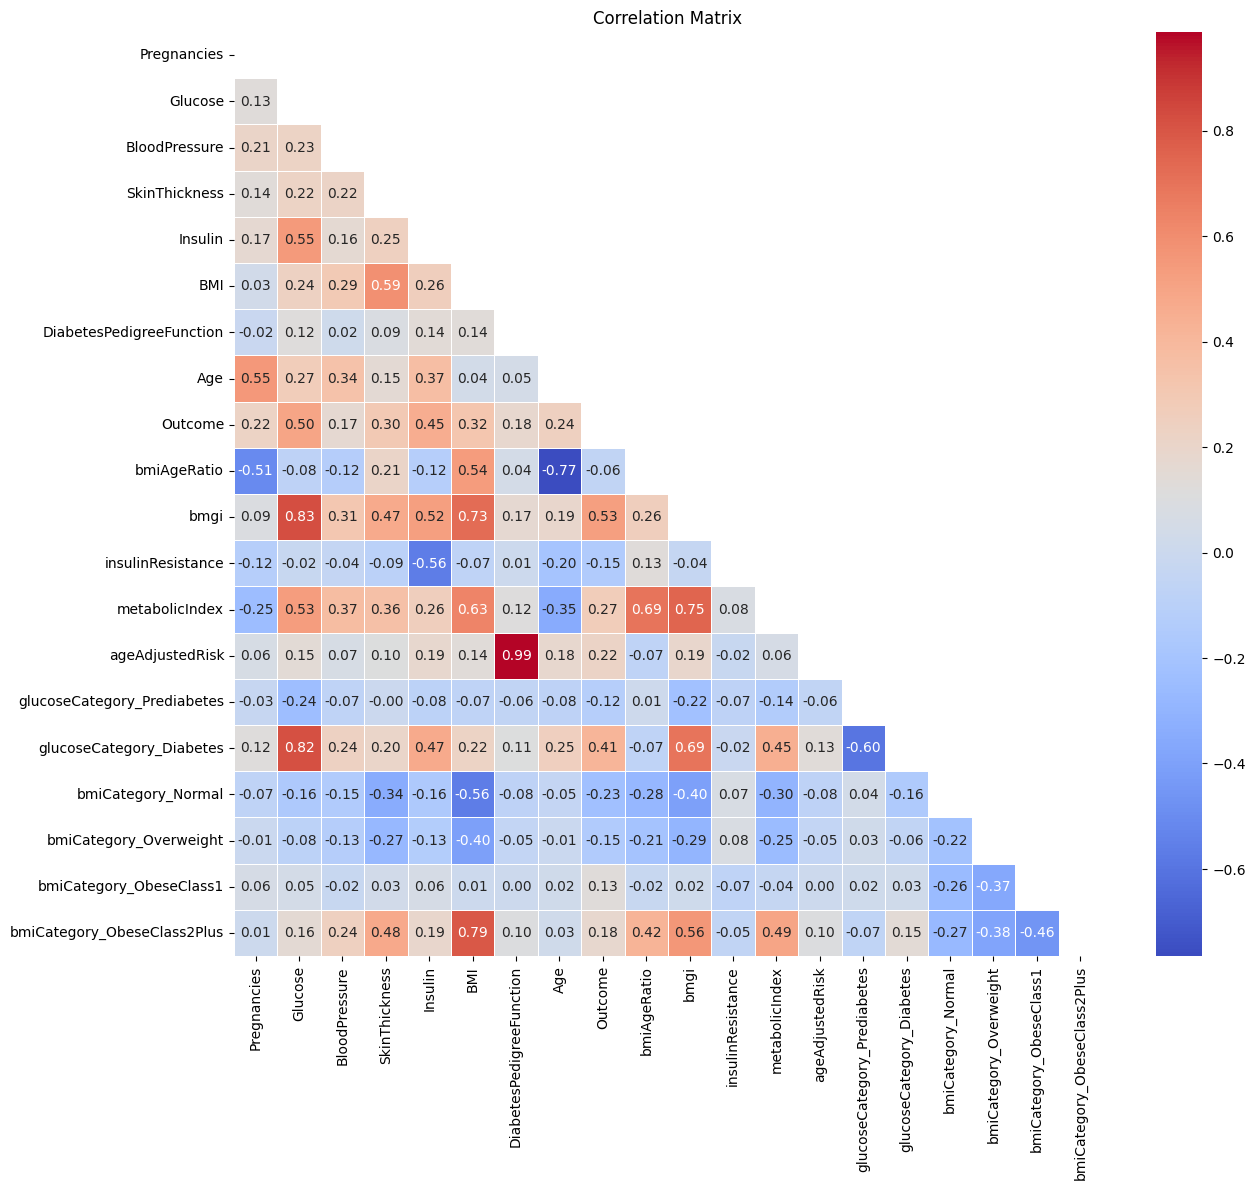

In [24]:
plt.figure(figsize=(14, 12))
correlationMatrix = dfFeatures.corr()
mask = np.triu(correlationMatrix.corr())
sns.heatmap(correlationMatrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

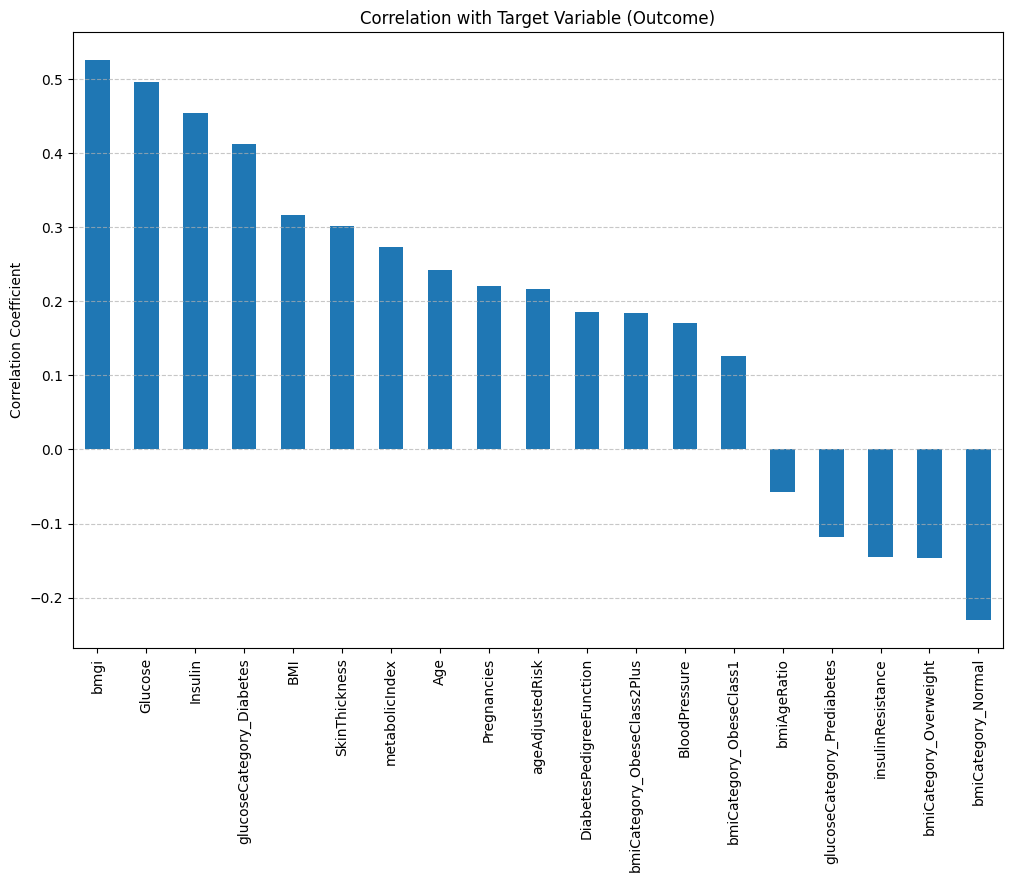

In [25]:
targetCorrelation = correlationMatrix['Outcome'].sort_values(ascending=False)
plt.figure(figsize=(12, 8))
targetCorrelation.drop('Outcome').plot(kind='bar')
plt.title('Correlation with Target Variable (Outcome)')
plt.ylabel('Correlation Coefficient')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Preparing data for modeling

In [26]:
X = dfFeatures.drop('Outcome', axis=1)
y = dfFeatures['Outcome']

In [27]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [28]:
print(f'XTrain dimensions: {XTrain.shape}')
print(f'XTest dimensions: {XTest.shape}')
print(f'yTrain dimensions: {yTrain.shape}')
print(f'yTest dimensions: {yTest.shape}')

XTrain dimensions: (576, 19)
XTest dimensions: (192, 19)
yTrain dimensions: (576,)
yTest dimensions: (192,)


#### Check class balance

In [29]:
print("\nClass distribution in training set:")
print(yTrain.value_counts(normalize=True) * 100)


Class distribution in training set:
Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64


In [30]:
print("\nClass distribution in test set:")
print(yTest.value_counts(normalize=True) * 100)


Class distribution in test set:
Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64


#### auxFunction to evaluate models comprehensively, idk that's just for aesthetics

In [31]:
def evaluateModel(model, XTrain, XTest, yTrain, yTest, modelName, cv=5):
    model.fit(XTrain, yTrain)
    
    yPred = model.predict(XTest)
    yProb = model.predict_proba(XTest)[:, 1] if hasattr(model, "predict_proba") else None

    trainScore = model.score(XTrain, yTrain)
    testScore = model.score(XTest, yTest)
    
    print(f" --- {modelName} Evaluation ---")
    print(f"Training accuracy: {trainScore:.4f}")
    print(f"Test accuracy: {testScore:.4f}")
    
    # Stratified cross-validation
    cvScores = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42))
    print(f"Cross-validation (CV={cv}): {cvScores.mean():.4f} ± {cvScores.std():.4f}")
    
    # Classification report
    print("\nClassification report:")
    print(classification_report(yTest, yPred))
    
    # Confusion matrix
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(model, XTest, yTest, cmap='Blues', colorbar=False)
    plt.title(f'Confusion Matrix - {modelName}')
    plt.show()
    
    # ROC curve (if model can calculate probabilities)
    if yProb is not None:
        fpr, tpr, _ = roc_curve(yTest, yProb)
        rocAuc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {rocAuc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {modelName}')
        plt.legend(loc="lower right")
        plt.show()
        
        # Precision-Recall curve 
        precision, recall, _ = precision_recall_curve(yTest, yProb)
        avgPrecision = average_precision_score(yTest, yProb)
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avgPrecision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {modelName}')
        plt.legend(loc="lower left")
        plt.show()
    
    return {
        'model': model,
        'trainScore': trainScore,
        'testScore': testScore,
        'cvScore': cvScores.mean(),
        'cvStd': cvScores.std()
    }

In [32]:
smote = SMOTE(random_state=42)
XTrainSmote, yTrainSmote = smote.fit_resample(XTrain, yTrain)

#### Check distribution after SMOTE

In [33]:
print("Class distribution after SMOTE:")
print(pd.Series(yTrainSmote).value_counts(normalize=True) * 100)

Class distribution after SMOTE:
Outcome
0    50.0
1    50.0
Name: proportion, dtype: float64


#### Compare dimensions

In [34]:
print(f"\nOriginal XTrain dimensions: {XTrain.shape}")
print(f"Dimensions after SMOTE: {XTrainSmote.shape}")


Original XTrain dimensions: (576, 19)
Dimensions after SMOTE: (750, 19)


## Modeling

In [35]:
def createPipeline(model): # Create a pipeline with scaling and the model (SVM requires scaling basically)
    return Pipeline([ ('scaler', StandardScaler()), ('model', model) ])

In [36]:
models = {
    'Random Forest': RandomForestClassifier(class_weight = 'balanced', random_state = 42),
    'SVM': SVC(probability = True, class_weight = 'balanced', random_state = 42),
    'XGBoost': XGBClassifier(scale_pos_weight = len(yTrainSmote[yTrainSmote == 0]) / len(yTrainSmote[yTrainSmote == 1]), random_state = 42)
}

results = {}

 --- Random Forest Evaluation ---
Training accuracy: 1.0000
Test accuracy: 0.8281
Cross-validation (CV=5): 0.8568 ± 0.0217

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       125
           1       0.74      0.78      0.76        67

    accuracy                           0.83       192
   macro avg       0.81      0.82      0.81       192
weighted avg       0.83      0.83      0.83       192



<Figure size 800x600 with 0 Axes>

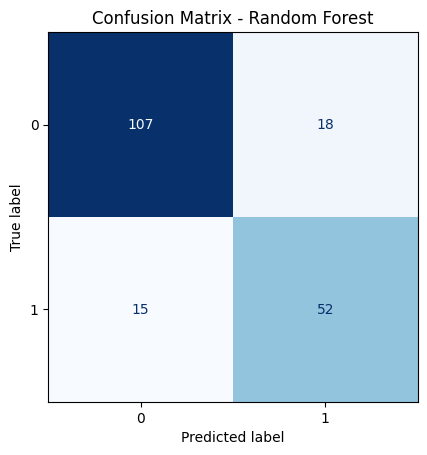

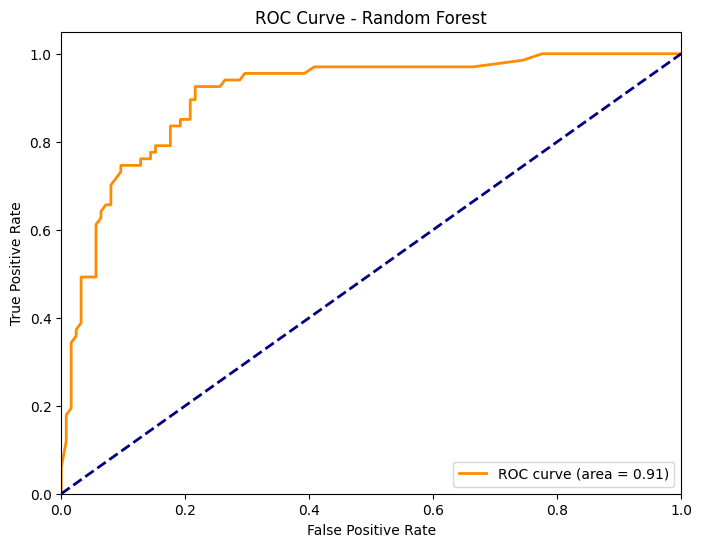

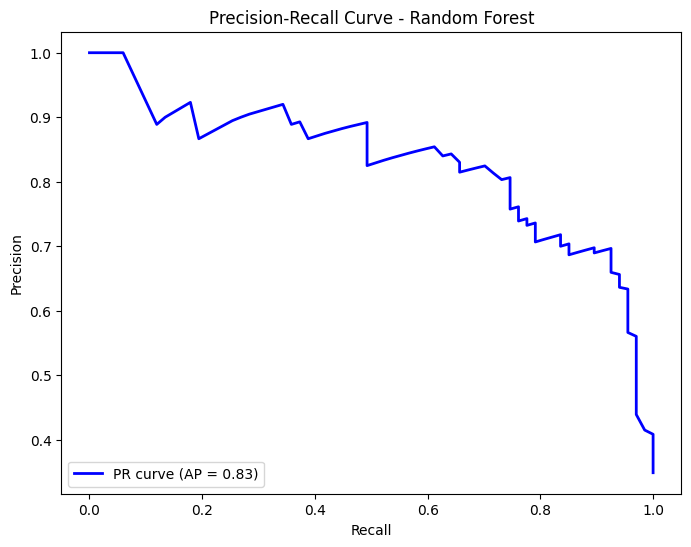

 --- SVM Evaluation ---
Training accuracy: 0.9067
Test accuracy: 0.8229
Cross-validation (CV=5): 0.7994 ± 0.0354

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       125
           1       0.73      0.79      0.76        67

    accuracy                           0.82       192
   macro avg       0.80      0.82      0.81       192
weighted avg       0.83      0.82      0.82       192



<Figure size 800x600 with 0 Axes>

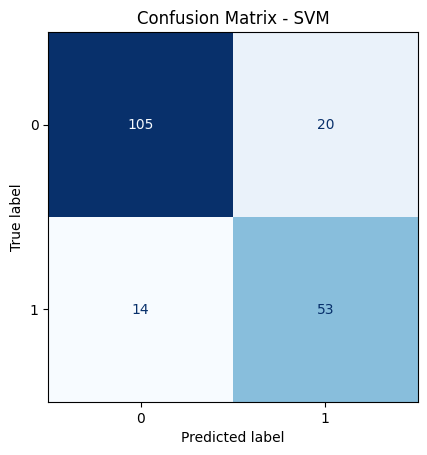

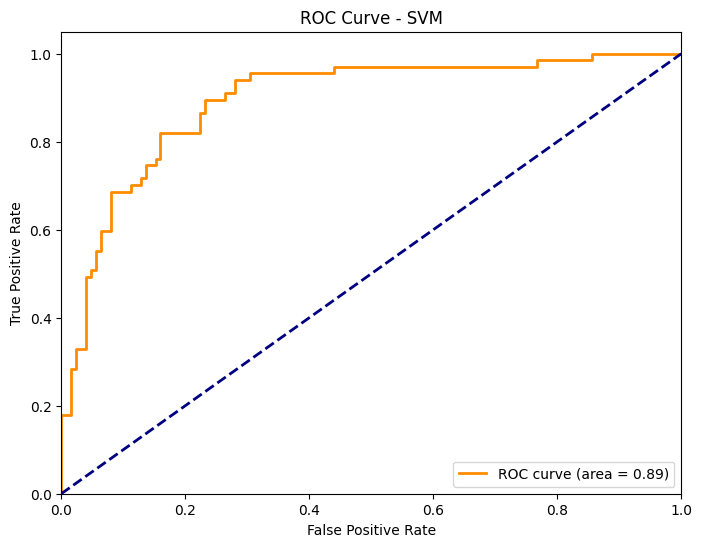

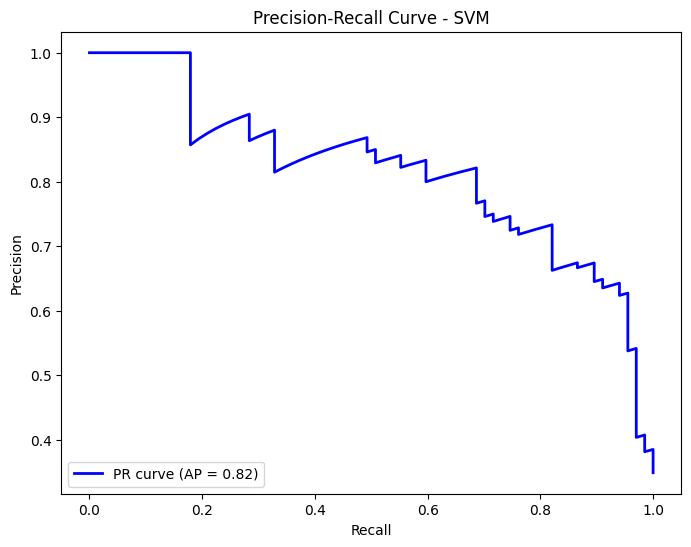

 --- XGBoost Evaluation ---
Training accuracy: 1.0000
Test accuracy: 0.8333
Cross-validation (CV=5): 0.8698 ± 0.0233

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       125
           1       0.75      0.78      0.76        67

    accuracy                           0.83       192
   macro avg       0.82      0.82      0.82       192
weighted avg       0.83      0.83      0.83       192



<Figure size 800x600 with 0 Axes>

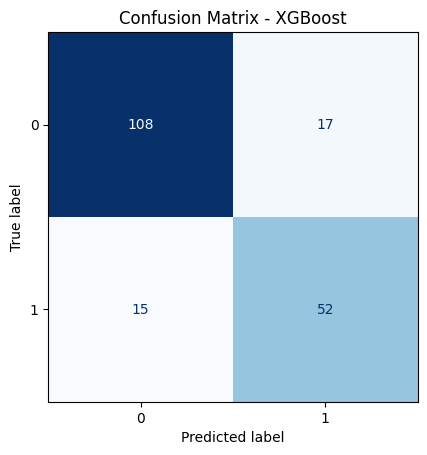

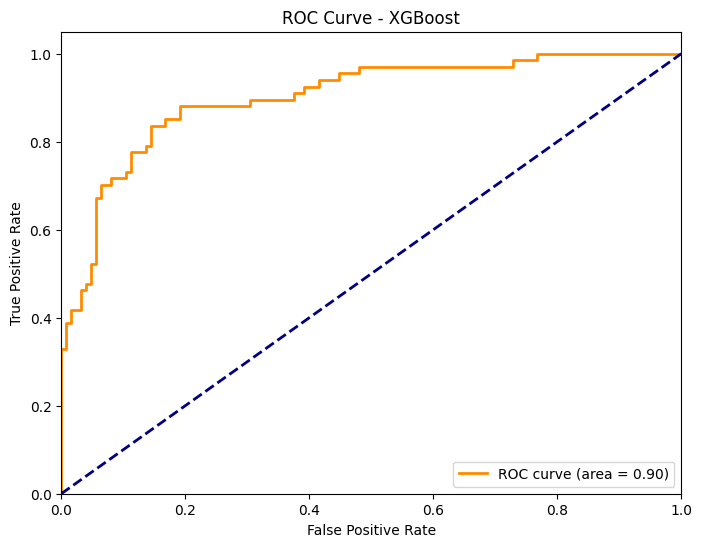

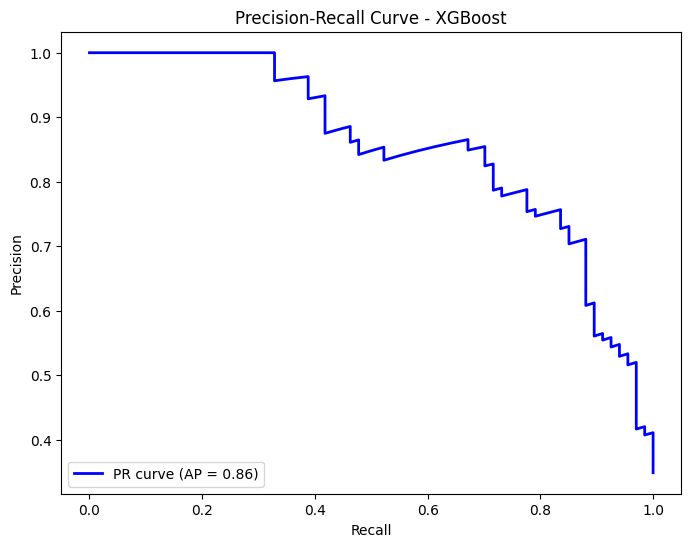

In [37]:
for name, model in models.items():
    pipeline = createPipeline(model)
    results[name] = evaluateModel(pipeline, XTrainSmote, XTest, yTrainSmote, yTest, name)

#### Hyperparameter optimization

In [38]:
bestModelName = max(results, key=lambda k: results[k]['testScore'])
print(f"The best model is: {bestModelName} with test accuracy of {results[bestModelName]['testScore']:.4f}")

The best model is: XGBoost with test accuracy of 0.8333


##### XGBoost Optimization

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'model__subsample': 0.8, 'model__n_estimators': 300, 'model__min_child_weight': 1, 'model__max_depth': 8, 'model__learning_rate': 0.01, 'model__gamma': 0.3, 'model__colsample_bytree': 0.8}
Best cross-validation score: 0.9046
 --- Optimized XGBoost Evaluation ---
Training accuracy: 0.9853
Test accuracy: 0.8490
Cross-validation (CV=5): 0.8802 ± 0.0165

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       125
           1       0.78      0.79      0.79        67

    accuracy                           0.85       192
   macro avg       0.83      0.84      0.83       192
weighted avg       0.85      0.85      0.85       192



<Figure size 800x600 with 0 Axes>

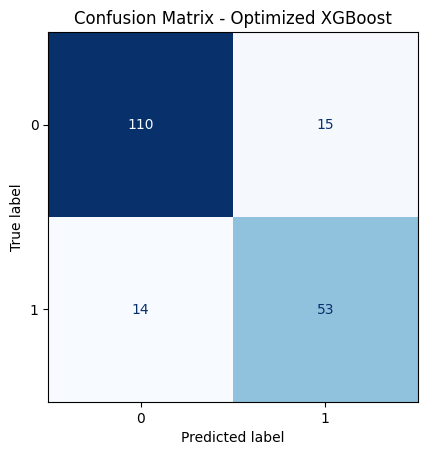

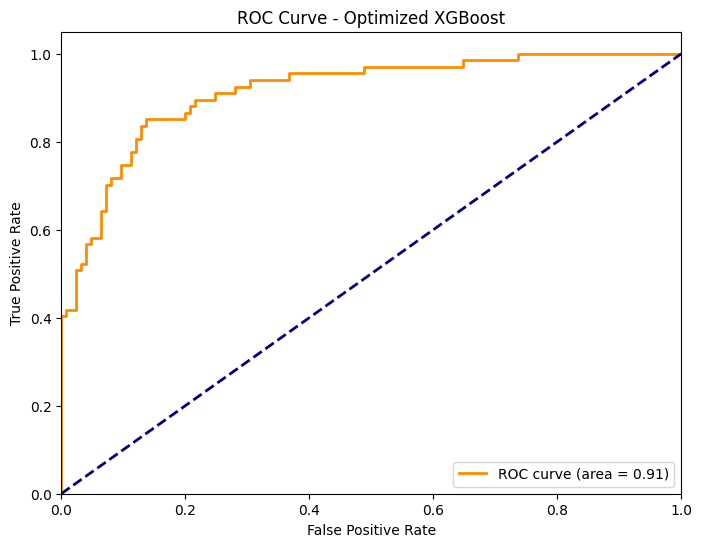

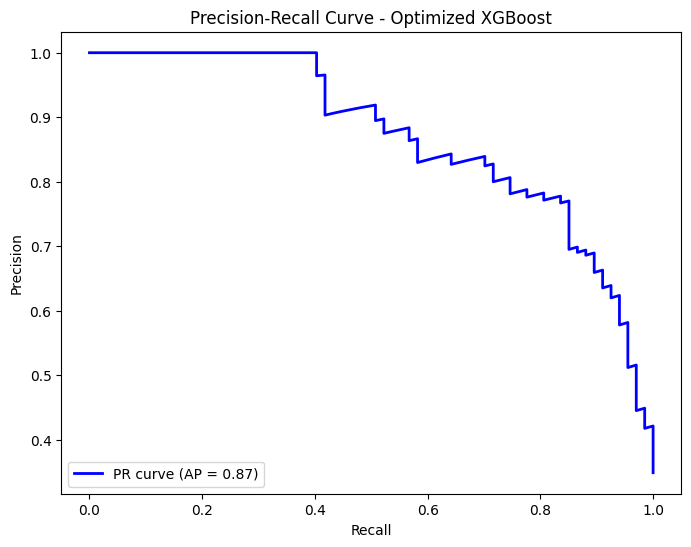

In [39]:
if bestModelName == 'XGBoost':    
    paramGrid = {
        'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'model__max_depth': [3, 4, 5, 6, 8],
        'model__min_child_weight': [1, 3, 5, 7],
        'model__gamma': [0, 0.1, 0.2, 0.3],
        'model__colsample_bytree': [0.6, 0.8, 1.0],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__n_estimators': [100, 200, 300]
    }
    
    baseModel = createPipeline(XGBClassifier(scale_pos_weight = len(yTrainSmote[yTrainSmote == 0]) / len(yTrainSmote[yTrainSmote == 1]), random_state=42))
   
    randomSearch = RandomizedSearchCV(
        baseModel,
        param_distributions=paramGrid,
        n_iter=25, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='f1',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    randomSearch.fit(XTrainSmote, yTrainSmote)

    print(f"Best parameters: {randomSearch.best_params_}")
    print(f"Best cross-validation score: {randomSearch.best_score_:.4f}")

    bestXgb = randomSearch.best_estimator_
    results['Optimized XGBoost'] = evaluateModel(bestXgb, XTrainSmote, XTest, yTrainSmote, yTest, 'Optimized XGBoost')

##### Feature selection to reduce potential overfitting

Feature importances for XGBoost:
                        feature  importance
4                       Insulin    0.240408
9                          bmgi    0.088697
1                       Glucose    0.073949
7                           Age    0.058220
11               metabolicIndex    0.056275
10            insulinResistance    0.054812
3                 SkinThickness    0.053664
8                   bmiAgeRatio    0.041754
14     glucoseCategory_Diabetes    0.040168
5                           BMI    0.037405
12              ageAdjustedRisk    0.036770
13  glucoseCategory_Prediabetes    0.034776
6      DiabetesPedigreeFunction    0.032674
18  bmiCategory_ObeseClass2Plus    0.032200
17      bmiCategory_ObeseClass1    0.031630
0                   Pregnancies    0.028798
2                 BloodPressure    0.026428
16       bmiCategory_Overweight    0.019291
15           bmiCategory_Normal    0.012081


 --- XGBoost Top Features Evaluation ---
Training accuracy: 1.0000
Test accuracy: 0.8

<Figure size 800x600 with 0 Axes>

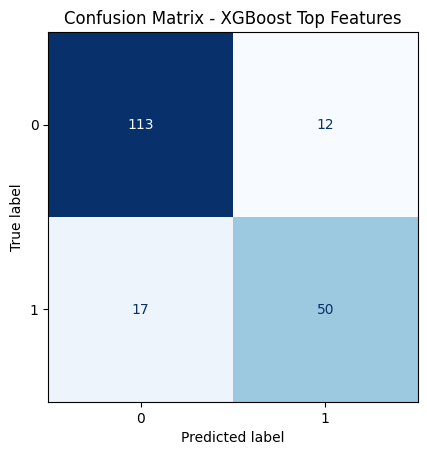

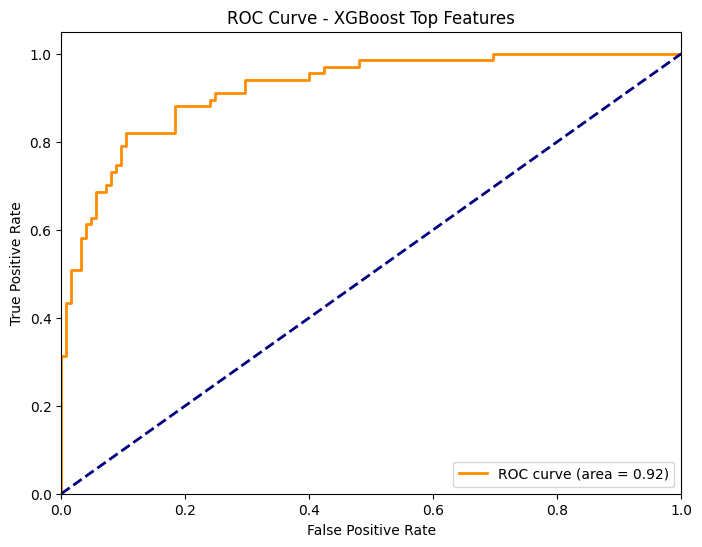

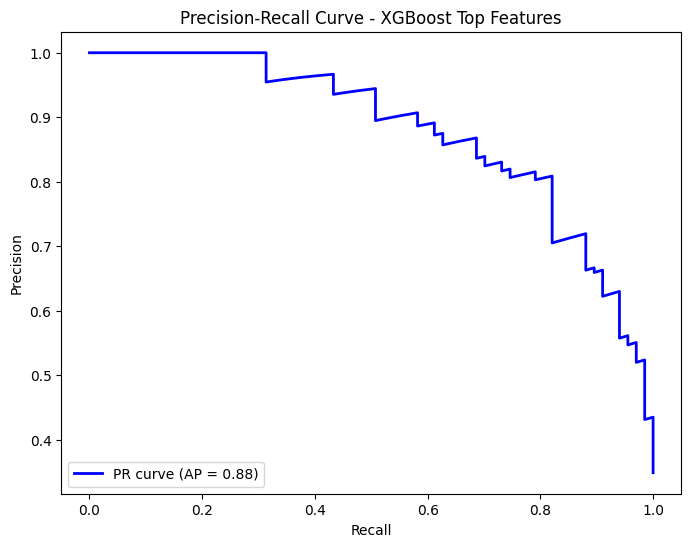

In [40]:
if 'Optimized XGBoost' in results:
    bestXgbModel = results['Optimized XGBoost']['model']
else:
    bestXgbModel = results['XGBoost']['model']

if isinstance(bestXgbModel, Pipeline):
    xgbModelInPipeline = bestXgbModel.named_steps['model']
    
    if hasattr(xgbModelInPipeline, 'feature_importances_'):
        importances = xgbModelInPipeline.feature_importances_
        featureImportance = pd.DataFrame({ 'feature': X.columns, 'importance': importances }).sort_values('importance', ascending=False)
        
        print("Feature importances for XGBoost:")
        print(featureImportance)
        print("\n")

        topFeatures = featureImportance.head(10)['feature'].tolist()
        XTopFeatures = X[topFeatures]
        XTrainTopFeatures = XTrain[topFeatures]
        XTestTopFeatures = XTest[topFeatures]
        XTrainSmoteTopFeatures, yTrainSmoteTopFeatures = smote.fit_resample(XTrainTopFeatures, yTrain)
        
        topFeaturesModel = createPipeline(XGBClassifier( scale_pos_weight = len(yTrainSmote[yTrainSmote == 0]) / len(yTrainSmote[yTrainSmote == 1]), random_state=42 ))
        
        results['XGBoost Top Features'] = evaluateModel(
            topFeaturesModel, 
            XTrainSmoteTopFeatures, 
            XTestTopFeatures, 
            yTrainSmoteTopFeatures, 
            yTest, 
            'XGBoost Top Features'
        )

##### Stacking ensemble to combine multiple models

 --- Stacking Ensemble Evaluation ---
Training accuracy: 1.0000
Test accuracy: 0.8438
Cross-validation (CV=5): 0.8672 ± 0.0184

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       125
           1       0.78      0.76      0.77        67

    accuracy                           0.84       192
   macro avg       0.83      0.82      0.83       192
weighted avg       0.84      0.84      0.84       192



<Figure size 800x600 with 0 Axes>

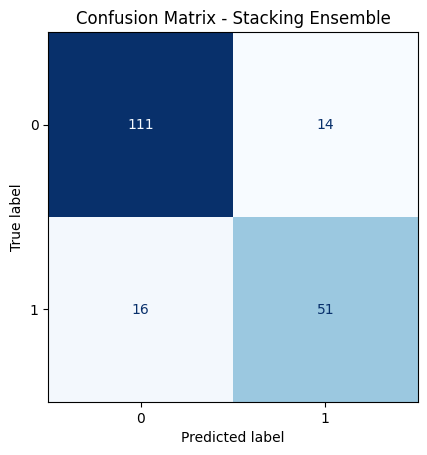

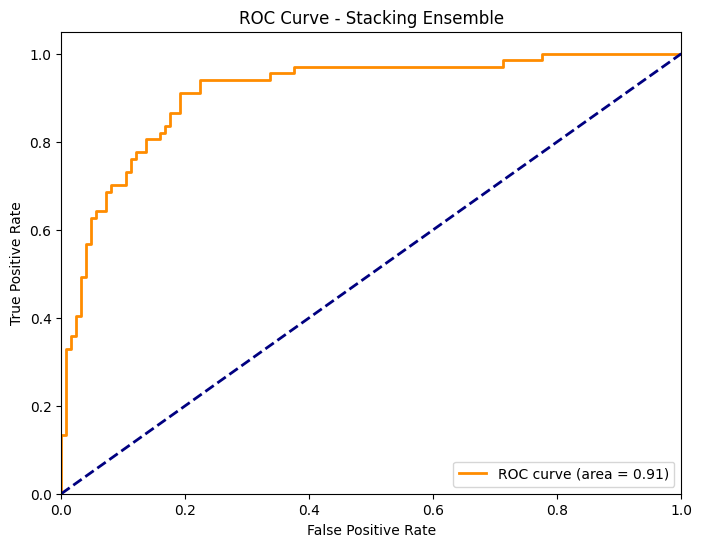

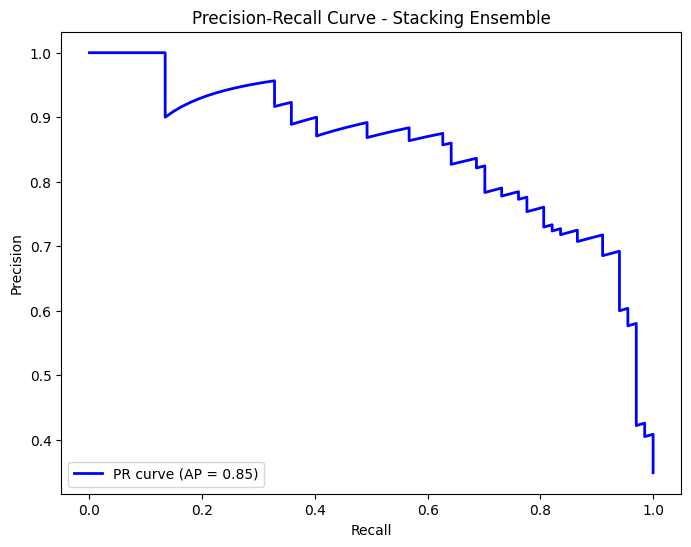

In [41]:

baseModels = [
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),          
    ('svm', SVC(probability=True, class_weight='balanced', random_state=42)),
    ('xgb', XGBClassifier(scale_pos_weight=len(yTrainSmote[yTrainSmote==0])/len(yTrainSmote[yTrainSmote==1]), random_state=42))
]

metaLearner = LogisticRegression(max_iter = 1000, class_weight = 'balanced')
stackingModel = StackingClassifier(estimators = baseModels, final_estimator = metaLearner, cv = 5, stack_method = 'predict_proba' )
stackingPipeline = Pipeline([ ('scaler', StandardScaler()), ('stacking', stackingModel) ])

results['Stacking Ensemble'] = evaluateModel(
    stackingPipeline, 
    XTrainSmote, 
    XTest, 
    yTrainSmote, 
    yTest, 
    'Stacking Ensemble'
)

##### Try different class weights or sampling techniques

In [42]:
smoteTomek = SMOTETomek(random_state=42) # SMOTETomek combines oversampling and undersampling
XTrainSmoteTomek, yTrainSmoteTomek = smoteTomek.fit_resample(XTrain, yTrain)

In [43]:
print("Class distribution after SMOTETomek:")
print(pd.Series(yTrainSmoteTomek).value_counts(normalize=True) * 100)

Class distribution after SMOTETomek:
Outcome
0    50.0
1    50.0
Name: proportion, dtype: float64


 --- XGBoost SMOTETomek Evaluation ---
Training accuracy: 1.0000
Test accuracy: 0.8385
Cross-validation (CV=5): 0.8698 ± 0.0233

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       125
           1       0.76      0.78      0.77        67

    accuracy                           0.84       192
   macro avg       0.82      0.82      0.82       192
weighted avg       0.84      0.84      0.84       192



<Figure size 800x600 with 0 Axes>

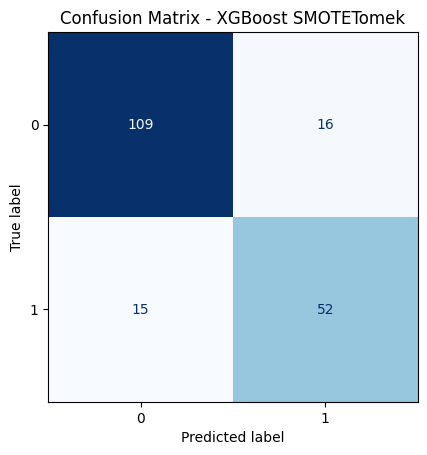

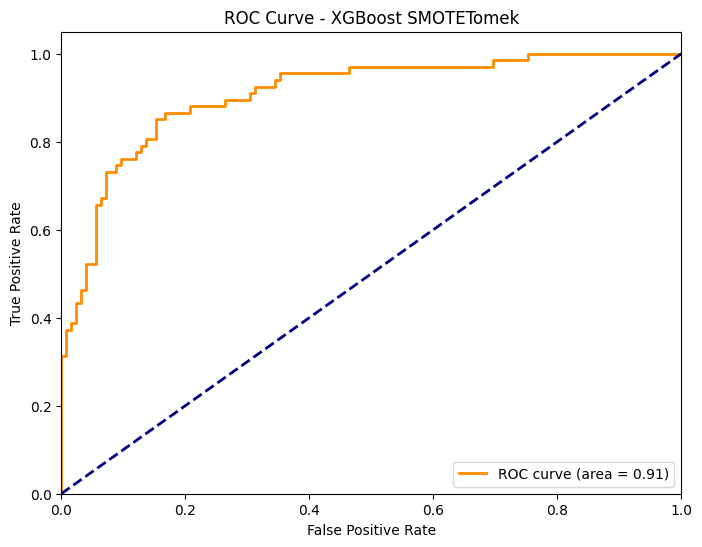

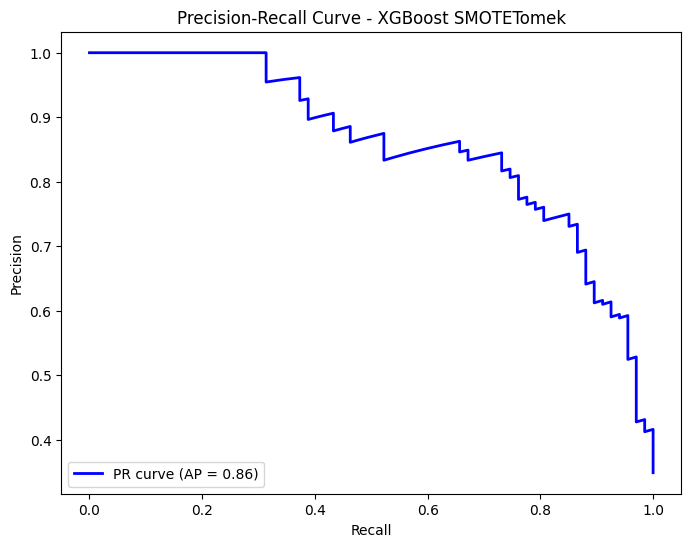

In [44]:
xgbSmoteTomek = createPipeline(XGBClassifier(random_state=42))
results['XGBoost SMOTETomek'] = evaluateModel(
    xgbSmoteTomek, 
    XTrainSmoteTomek, 
    XTest, 
    yTrainSmoteTomek, 
    yTest, 
    'XGBoost SMOTETomek'
)

## Compare all models based on test accuracy

In [45]:
modelComparison = pd.DataFrame({
    'model': list(results.keys()),
    'testAccuracy': [results[model]['testScore'] for model in results],
    'cvScore': [results[model]['cvScore'] for model in results]
}).sort_values('testAccuracy', ascending=False)

In [46]:
print("Model comparison:")
print(modelComparison)

Model comparison:
                  model  testAccuracy   cvScore
3     Optimized XGBoost      0.848958  0.880239
4  XGBoost Top Features      0.848958  0.869850
5     Stacking Ensemble      0.843750  0.867227
6    XGBoost SMOTETomek      0.838542  0.869850
2               XGBoost      0.833333  0.869850
0         Random Forest      0.828125  0.856786
1                   SVM      0.822917  0.799431


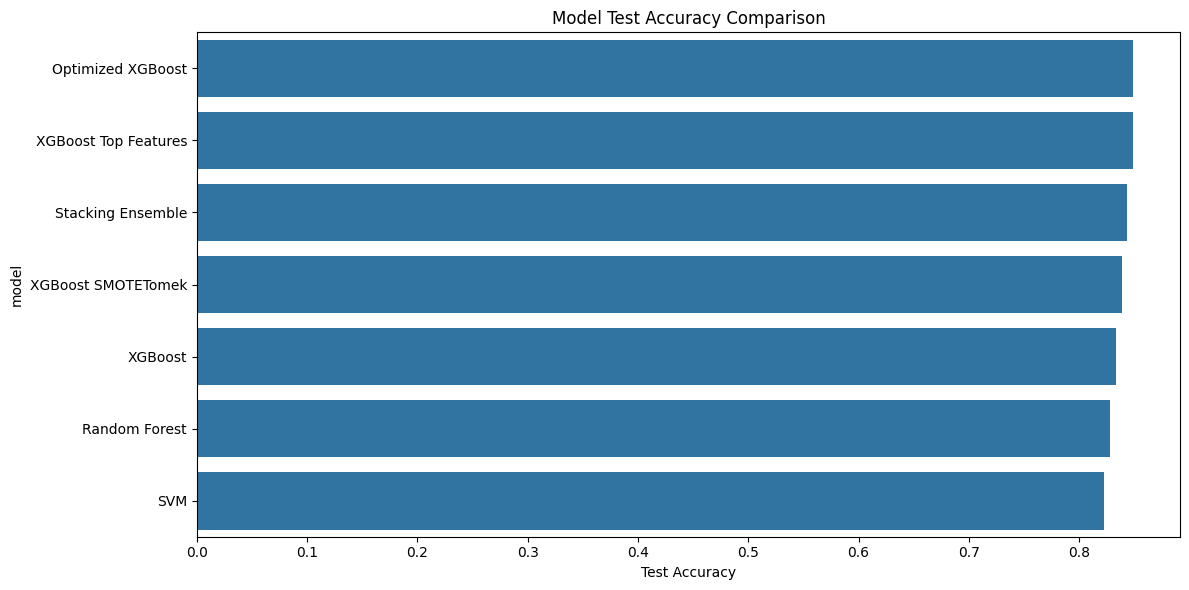

In [47]:
plt.figure(figsize=(12, 6))
sns.barplot(x='testAccuracy', y='model', data=modelComparison)
plt.title('Model Test Accuracy Comparison')
plt.xlabel('Test Accuracy')
plt.tight_layout()
plt.show()

In [48]:
bestModelOverall = modelComparison.iloc[0]['model']
modelToSave = results[bestModelOverall]['model']

joblib.dump(modelToSave, 'bestDiabetesModel.pkl')

['bestDiabetesModel.pkl']